In [1]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install -q -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

  Obtaining dependency information for tf-models-official==2.13.* from https://files.pythonhosted.org/packages/d8/c3/4511e49412492966f4e6e0a20b41ae66d027e5a76e8c2b436b591ecc4273/tf_models_official-2.13.2-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.2 MB/s eta 0:00:00
  Obtaining dependency information for immutabledict from https://files.pythonhosted.org/packages/77/d8/69b89c358609ef1853d860bcf59472abe65e2c434767e6e91c57e12e5c23/immutabledict-4.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for sacrebleu from https://files.pythonhosted.org/packages/0a/a6/2ac47e71e526bbcd97ea08f20d9ef7d3852e2594ec7b2d55f5d2bbfd7aae/sacrebleu-2.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from official.nlp import optimization
import os
import pandas as pd
from urllib.request import urlretrieve

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset = pd.read_csv("/kaggle/input/ektrovert-introvert-dataset/dataset_ei.csv")
dataset = dataset.drop('type', axis=1)
# Cetak dataset pelatihan
print("List Dataset:")
print(dataset)

List Dataset:
    label                                                 EI
0       I  Saya cenderung suka menjalani waktu sendiri, l...
1       I  Saya adalah orang yang cenderung teratur dan t...
2       I  Saya cenderung lebih suka bekerja sendiri, tet...
3       I  Saya adalah tipe orang yang cenderung suka men...
4       I  Saya cenderung mengamati dan merenung dalam di...
..    ...                                                ...
315     E  saya sering menjalin hubungan dengan banyak or...
316     E  Tidak suka jika tidak memimpin dan tidak mengo...
317     E  Tidak suka jika hanya diam mengikuti arus situ...
318     E  Dalam interaksi sosial, saya cenderung tidak p...
319     E  Dalam interaksi dengan orang lain, tidak jaran...

[320 rows x 2 columns]


In [4]:
df = pd.DataFrame(dataset)
df['EI'] = df['EI'].str.strip()

# Membagi dataset berdasarkan kelompok
grouped = df.groupby('label')

# Inisialisasi DataFrame train dan valid
df_train = pd.DataFrame()
df_valid = pd.DataFrame()

# Memproses setiap kelompok
for name, group in grouped:
    # Menentukan jumlah data untuk validasi
    valid_size = int(len(group) * 0.2)

    # Memilih data untuk validasi
    valid_data = group.sample(n=valid_size, random_state=42)

    # Memilih data untuk train
    train_data = group.drop(valid_data.index)

    # Menggabungkan hasil pemisahan ke dalam DataFrame train dan valid
    df_train = pd.concat([df_train, train_data])
    df_valid = pd.concat([df_valid, valid_data])

#acak
df_train = df_train.sample(frac=1, random_state=42)
df_valid= df_valid.sample(frac=1, random_state=42)

# Cetak hasil
print("Data Train:")
print(df_train)
print("\nData Valid:")
print(df_valid)

Data Train:
    label                                                 EI
205     I  Ga jarang, gue ngelakuin sesuatu berdasarkan p...
86      E  Seringkali menemukan diri saya di tengah kerum...
259     E  Saya suka banget bertemu orang baru dan ngobro...
176     I  Tidak suka jika tidak mengamati detail-detail ...
308     E  Di peternakan, saya suka menjadi pusat perhati...
..    ...                                                ...
293     E  Saya menjadi magnet sosial yang tak terelakkan...
100     E  Saya sebagai seseorang yang suka berinteraksi ...
277     E  Saya menemukan kepuasan dalam berkolaborasi se...
64      I  Saya cenderung suka menyendiri, lebih nyaman d...
287     E  Meskipun tidak selalu mencari perhatian sesama...

[256 rows x 2 columns]

Data Valid:
    label                                                 EI
75      I  Sering kali berada dalam pikiran sendiri, kada...
177     I  Orang-orang yang dikenalnya merasa nyaman di s...
265     E  Saya bukanlah tipe orang 

In [5]:
train_data = df_train
valid_data = df_valid
target_label = 'E' #label 1 Ekstrovert #label 1 Sensing #label 1 feeling #label 1 perceiving
label_train = (train_data['label'].str[0] == target_label).astype(int).to_numpy()
label_valid = (valid_data['label'].str[0] == target_label).astype(int).to_numpy()

In [6]:
x_train = train_data['EI'].to_numpy() #isi sesuai kolom dataset
x_valid = valid_data['EI'].to_numpy()
print(x_train.shape,x_valid.shape)
print(label_train)
print(x_train)

(256,) (64,)
[0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1
 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1
 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1
 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0
 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0
 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1
 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1]
['Ga jarang, gue ngelakuin sesuatu berdasarkan pemikiran rasional, lebih ke logika daripada emosi. Ketika ada masalah, gue ga pernah minta orang lain buat cariin solusi, lebih mengandalkan diri sendiri.'
 'Seringkali menemukan diri saya di tengah kerumunan orang, menikmati momen-momen spontan dan mengambil keputusan cepat'
 'Saya suka banget bertemu orang baru dan ngobrol seru bareng mereka. Kalau ketemu orang baru saya nggak bisa diem-dieman'
 'Tidak suka jika t

In [7]:
encoder_url = '/kaggle/input/bert/tensorflow2/multi-cased-l-12-h-768-a-12/4'
preprocess_url = "/kaggle/input/bert/tensorflow2/multi-cased-preprocess/3"

In [8]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='KerasLayer')
class KerasLayerWrapper(hub.KerasLayer):
    pass

def build_classifier_model():
    text_input1 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_EI')
    preprocessing_layer1 = KerasLayerWrapper("/kaggle/input/bert/tensorflow2/multi-cased-preprocess/3", name='bert_preprocessing_EI')
    encoder_inputs1 = preprocessing_layer1(text_input1)
    encoder1 = KerasLayerWrapper('/kaggle/input/bert/tensorflow2/multi-cased-l-12-h-768-a-12/4', name='bert_encoder_EI',trainable=True)
    outputs1 = encoder1(encoder_inputs1)['pooled_output']
    
    outputs1 = tf.keras.layers.Dropout(0.5 , name="dropout_1")(outputs1)
    outputs1 = tf.keras.layers.Flatten()(outputs1)
    outputs1 = tf.keras.layers.Reshape((1, -1))(outputs1)
    outputs1 = tf.keras.layers.LSTM(64, return_sequences=True)(outputs1)
    outputs1 = tf.keras.layers.LSTM(64)(outputs1)
    outputs1 = tf.keras.layers.Dense(512, activation='relu')(outputs1)

    label1 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier_EI')(outputs1)
    return tf.keras.Model(inputs=[text_input1], outputs=[label1])

In [9]:
model = build_classifier_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_EI (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 bert_preprocessing_EI (Ker  {'input_mask': (None, 128)   0         ['text_EI[0][0]']             
 asLayerWrapper)             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

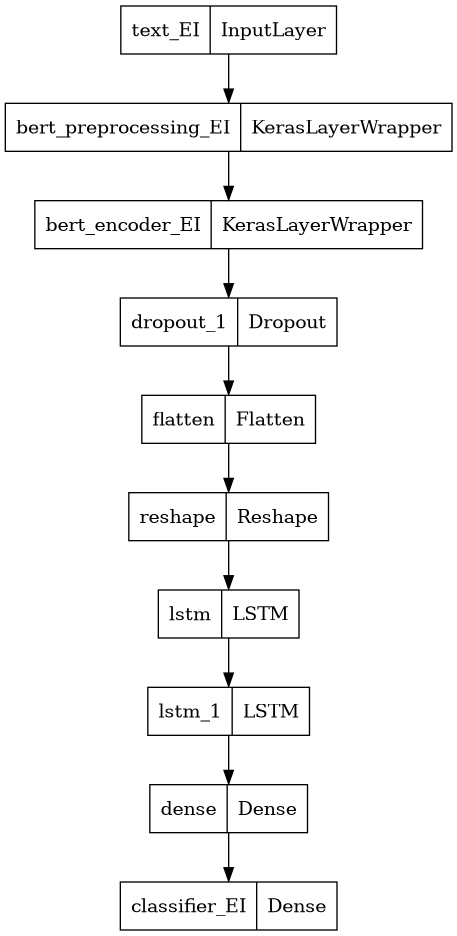

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
epochs = 5
steps_per_epoch = 16
batch_size = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

In [12]:
!pip install -q tf-models-official

In [13]:
# model.compile(optimizer=optimizer,
#                          loss=loss,
#                          metrics=metrics)
# model.load_weights("/content/drive/MyDrive/model_checkpoint_best.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss=tf.keras.losses.BinaryCrossentropy(),  # Fungsi kerugian untuk klasifikasi biner
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Path untuk menyimpan checkpoint pada setiap epoch
checkpoint_path_epoch = "/kaggle/working/model_checkpoint_epoch.h5"

# Path untuk menyimpan checkpoint model terbaik
checkpoint_path_best = "/kaggle/working/model_checkpoint_best.h5"

# Callback untuk menyimpan checkpoint pada setiap epoch
checkpoint_callback_epoch = ModelCheckpoint(
    filepath=checkpoint_path_epoch,
    save_weights_only=True,
    save_best_only=False,  # Set ke False agar menyimpan pada setiap epoch
    verbose=1
)

# Callback untuk menyimpan checkpoint model terbaik
checkpoint_callback_best = ModelCheckpoint(
    filepath=checkpoint_path_best,
    save_weights_only=True,
    save_best_only=True,  # Set ke True agar hanya menyimpan model terbaik
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [15]:
# untuk lanjut
model.fit(
    x=x_train, y=label_train,
    epochs=100,
    validation_data=(x_valid, label_valid),batch_size=batch_size,
    callbacks=[checkpoint_callback_epoch,checkpoint_callback_best]
)

Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4805
Epoch 1: saving model to /kaggle/working/model_checkpoint_epoch.h5

Epoch 1: val_loss improved from inf to 0.69314, saving model to /kaggle/working/model_checkpoint_best.h5
128/128 [==============================] - 72s 196ms/step - loss: 0.6932 - accuracy: 0.4805 - val_loss: 0.6931 - val_accuracy: 0.4688
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4570
Epoch 2: saving model to /kaggle/working/model_checkpoint_epoch.h5

Epoch 2: val_loss improved from 0.69314 to 0.69312, saving model to /kaggle/working/model_checkpoint_best.h5
128/128 [==============================] - 17s 131ms/step - loss: 0.6932 - accuracy: 0.4570 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4609
Epoch 3: saving model to /kaggle/working/model_checkpoint_epoch.h5

Epoch 3: val_loss impro

In [16]:
# tf.saved_model.save(embedding_model1, "fine_tuned")
model.save("model.h5", include_optimizer=False)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
model.load_weights('/kaggle/working/model_checkpoint_best.h5')

In [18]:
model.predict(["Saat bersama teman-teman, saya tidak senang jika tidak mendengarkan cerita mereka dan selalu memberikan dukungan yang mereka butuhkan"])

1/1 [==============================] - 1s 1s/step


array([[0.11422557]], dtype=float32)

In [19]:
# Mendapatkan daftar perangkat yang tersedia (CPU dan GPU)
devices = tf.config.list_physical_devices()

if len(devices) == 0:
    print("Tidak ada perangkat fisik yang ditemukan.")
else:
    print("Perangkat yang tersedia:")
    for device in devices:
        print(f"- {device.name} ({device.device_type})")

Perangkat yang tersedia:
- /physical_device:CPU:0 (CPU)
- /physical_device:GPU:0 (GPU)


In [20]:
print(model.predict(["sayap pergi sangat mudah temukan berhubungan setiap enneagram infj langka mustahil tidak mungkin semuanya mungkin tergantung naikkan cuure dll menang temukan banyak enneagram individualis di korea utara contoh mungkin kamp konsentrasi mh tebak akan membantu akan menemukan dosa mematikan lihat masalah lol iri sangat jelas tidak puas salah satu favorit katakan agak suka menyalin mekanisme seperti tidak ada hal semuanya akan baik-baik saja mungkin berpengaruh dengan baik semoga memperbaiki kerakusan di bawah kendali kecuali menggoda rumah coklat makan semuanya suatu hari gulma merokok tidak ada yang meninggalkan orang yang terlalu marah berarti kencing lelucon inti mempengaruhi banyak prolly w bermain dengan baik seseorang sesuatu yang terbelakang cara perlahan-lahan membuat gila seperti tahu seperti hei mengemudi kayu tengah tidak ada tempat duduk biarkan mengambil roda mobil duduk menang dapat mengemudi lagi hei paling tidak bisa duduk hahahahah ieriozuepoanhceiphfiozejfijrioe berhenti contoh buruk cukup mudah-mudahan memperbaiki fokus pikiran yang sadar akan sangat membantu dengan baik mungkin membutuhkan waktu pada akhirnya menjadi jelas kirim sesuatu mungkin perlu perubahan tahu partikal diskrit berpikir sebagian besar berpikir cara terhitung banyaknya bayangkan paling tidak mendekati sesuatu yang diskrit bahkan seperti fungsi tidak pernah cukup konvergen masalah fungsi kontinu topps mengurutkan basis deteksi emulasi menggunakan perangkat lunak tertentu menggunakan tujuan perangkat lunak bahkan meniru akan memicu perma larangan membeli paket skema baru-baru ini berharap satu opsi izinkan giliran animasi ingin mengenai paket kartu tambahkan stok perlu melihat paket terbuka pasti ingin melihat sumber daya jelek hit ringan terjadi kartu pertama oleh karena itu tutup waktu paket berhenti buka paket paling tidak akan cepat secara teoritis topps dapat memperkenalkan opsi pembelian mui akan sangat buruk aplikasi setidaknya tombol pembelian paket manual lambat pembeli besar pembeli kecil dapatkan paket populer jika tidak, paus dapat sepenuhnya membeli kartu satu pembelian tahu benar berani orang berpikir percaya hal mengatakan dunia pukulan tongkat mengapung selamanya ruang membekukan bola mati lemas mampu membuat kesepakatan kesengsaraan dua secara profesional mengakhiri kebencian cocok stereotip buruk keras suka memerintah kaku tak kenal ampun menurunkan semangat menjengkelkan satu mitra bisnis bertarung dengan keras secara agresif menunggu satu sama lain departemen pekerjaan yang berbeda mempengaruhi pekerjaan orang menjengkelkan yang menyedihkan membuat semua orang di sekitar menderita harapan bertemu dengan contoh yang baik sosiopat masa depan imo mengatakan dengan tepat satu akan mengatakan edit oh terima kasih Tuhan semua orang mendapatkan keramahan yang rendah jujur ?de?????de????menang mudah intj entj fungsi urutan yang berbeda intjs seperti banyak introvert sering memimpin fungsi tambahan situasi sosial perbedaan besar entjs kebutuhan tinggi menyelesaikan hal intjs kebutuhan tinggi secara akurat memahami intjs datang menggigit lalai ni biarkan kepala hidup gunakan te secara proaktif menjaga lebih memilih dukungan lingkungan ni mampu menjaga tatanan lingkungan ideal dengan benar mengarahkan energi ke dalam entj gunakan ni melayani te gunakan refleksi prediksi memesan tujuan satu cara mungkin membedakan reaksi gangguan lingkungan intj menjengkelkan seperti perbaikan hebat mendapatkan kembali hal yang sangat peduli entj oportunistik berpikir peluang besar mengatur ulang cara pasti enfps cinta istjs baik gender teman enfps kreativitas semangat hidup menemukan sangat menarik sensitivitas bebas semangat keseimbangan dingin kekakuan tambahan fi tersier te temukan di antara orang-orang yang sangat memahami nilai pandangan dunia bahkan setuju meskipun istjs berbagi fungsi sering menemukan tangkapan membatasi si konotasi teman monster monster berpikir pengungkapan penuh entj bisnis pesanan biasa yaitu menginjak-injak menggambarkan monster seperti romantisisasi yang tidak perlu sama sekali sarung pedang dll melayani gangguan mungkin mengambil fakta berhenti memberi tahu op monster"]))

1/1 [==============================] - 0s 43ms/step
[[0.8077502]]
